In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.envs.darkroom import DarkroomEnv

# Load Model

In [2]:
recalc_results = False

In [3]:
corr = 0.25
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "darkroom_simple")

epoch=13-val_loss=0.911523.ckpt


In [4]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))
maze_dim = int(re.search(r'_dim(\d+)_corr', eval_dset_path).group(1))
node_encoding_corr = float(re.search(r'corr(\d*\.?\d*)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": state_dim,
    "action_dim": 5,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [5]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')

/tmp/ipykernel_2519549/4170590101.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Helper Functions

In [6]:
n_eval_envs = 100

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    eval_trajs = [eval_trajs[i] for i in traj_indices]
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    random.seed(0)
    eval_trajs = random.sample(eval_trajs, n_eval_envs)
    random.seed()


In [7]:
def run_model(traj, model, state_features, seq_length, zero_reward=False):
    hidden_states = [[] for _ in range(model.n_layer)]
    
    for state_feature in state_features: 
        batch = {
            'context_states': convert_to_tensor([np.array(traj['context_states'])]),
            'context_actions': convert_to_tensor([np.array(traj['context_actions'])]),
            'context_next_states': convert_to_tensor([np.array(traj['context_next_states'])]),
            'context_rewards': convert_to_tensor([np.array(traj['context_rewards'])[:, None]]),
            'query_states': convert_to_tensor([np.array(state_feature)]),
            }
        batch['zeros'] = torch.zeros(1, 10 ** 2 + 4 + 1).float()
        for k in batch.keys():
            if 'context' in k:
                batch[k] = batch[k][:,:seq_length]
            batch[k] = batch[k].to(model.device)
        model.save_activations = True
        if zero_reward:
            batch['context_rewards'] *= 0
        with torch.no_grad():
            out = model(batch)
        _hidden_states = model.activations['hidden_states'][1:] # Tuple over layers
        for i_layer in range(model.n_layer):
            hidden_states[i_layer].append(_hidden_states[i_layer])
    return hidden_states

In [8]:
def get_kernel_alignment(K_A, K_B):
    """ Centered Kernel Alignment """
    n = K_A.shape[0]
    I = np.eye(n)
    H = I - np.ones((n, n)) / n
    K_A_centered = H @ K_A @ H
    K_B_centered = H @ K_B @ H
    
    # Compute alignment using Frobenius norm
    numerator = np.sum(K_A_centered * K_B_centered)
    denominator = np.sqrt(np.sum(K_A_centered * K_A_centered) * np.sum(K_B_centered * K_B_centered))
    
    return numerator / denominator if denominator != 0 else 0

In [9]:
dist_func = lambda data: squareform(pdist(data, metric='correlation'))
#dist_func = lambda data: squareform(pdist(data))

def get_dist_metric(hidden_states, true_dist_matrix, gamma, random_ctrl=False):
    kas = []
    dist_matrices = []
    K_input = gamma**true_dist_matrix # exponential kernel

    for layer in range(len(hidden_states)):
        X = torch.stack(hidden_states[layer])
        X = X.detach().cpu().numpy().squeeze()  # (states, sequence length, hidden dim)
        data = X[:, -1, :]  # Response when given last (query) token
        if random_ctrl:
            np.random.shuffle(data)

        representation_dist_matrix = dist_func(data)
        clip_val = np.percentile(representation_dist_matrix, 99)
        representation_dist_matrix = np.clip(representation_dist_matrix, None, clip_val)
        representation_dist_matrix = representation_dist_matrix / representation_dist_matrix.max()

        data -= data.mean(0)[None,:]
        K_latents = data @ data.T
        kernel_alignment = get_kernel_alignment(K_input, K_latents)
        kas.append(kernel_alignment)
        dist_matrices.append(representation_dist_matrix)
    return kas, dist_matrices

# Collect Kernel Alignment Results

In [10]:
if recalc_results:
    dist_results = {
       'seq_length': [],
       'layer': [],
       'diff': [], 
       'random_diff': [],
       'diff_no_reward': [],
       'gamma': []
    }
    baseline_dist_results = {
        'diff': [],
        'gamma': []
    }
    for i_eval in range(len(eval_trajs)):
        traj = eval_trajs[i_eval]
        env_config = {
            'maze_dim': maze_dim,
            'horizon': 200,
            'state_dim': state_dim,
            'node_encoding_corr': node_encoding_corr,
            'initialization_seed': np.array(traj['initialization_seed']).item(),
            'goal': np.array(traj['goal'])
        }
        env = DarkroomEnv(**env_config)
        
        # Collect state features
        xs = []
        ys = []
        state_features = []
        state_features = list(env.node_map_encoding_to_pos.keys())
        for state_feature in state_features:
            xs.append(env.node_map_encoding_to_pos[state_feature][0])
            ys.append(env.node_map_encoding_to_pos[state_feature][1])
        reward_idx = np.argwhere([np.all(s == env.goal) for s in state_features]).item() 
        
        # Get true distance kernel
        true_dist_matrix = []
        for state_feature in state_features:
            _, dist_from_state = env._make_opt_action_dict(state_feature)
            sorted_dist_from_state = []
            for state_feature in state_features:
                sorted_dist_from_state.append(dist_from_state[state_feature])
            true_dist_matrix.append(sorted_dist_from_state)
        true_dist_matrix = np.array(true_dist_matrix)
    
        seq_lengths = np.arange(0, 260, 10)
        seq_lengths[0] = 1
        for seq_length in seq_lengths:
            hidden_states = run_model(traj, model, state_features, seq_length)
            hidden_states_no_reward = run_model(traj, model, state_features, seq_length, zero_reward=True)
    
            for gamma in np.arange(0.1, 1., 0.1):
                diffs, dist_matrices = get_dist_metric(hidden_states, true_dist_matrix, gamma)
                random_diffs, _ = get_dist_metric(hidden_states, true_dist_matrix, gamma, random_ctrl=True)
                diffs_no_reward, _ = get_dist_metric(hidden_states_no_reward, true_dist_matrix, gamma)
                dist_results['seq_length'].extend([seq_length] * model.n_layer)
                dist_results['layer'].extend(range(model.n_layer))
                dist_results['diff'].extend(diffs)
                dist_results['random_diff'].extend(random_diffs)
                dist_results['diff_no_reward'].extend(diffs_no_reward)
                dist_results['gamma'].extend([gamma] * model.n_layer)

            # Clear GPU memory
            del hidden_states
            del hidden_states_no_reward
            torch.cuda.empty_cache()

        # Get baseline kernel alignment from input features
        for gamma in np.arange(0.1, 1., 0.1):
            state_features_tensor = np.array(state_features)
            state_features_tensor -= state_features_tensor.mean(0)[None,:]
            K_latents = state_features_tensor @ state_features_tensor.T
            K_input = gamma**true_dist_matrix 
            kernel_alignment = get_kernel_alignment(K_input, K_latents)
            baseline_dist_results['diff'].append(kernel_alignment)
            baseline_dist_results['gamma'].append(gamma)

    dist_results = pd.DataFrame(dist_results)
    baseline_dist_results = pd.DataFrame(baseline_dist_results)
    with open('pickles/03_representation_structure_kernel_alignment_summary.pkl', 'wb') as f:
        pickle.dump(
            {'dist_results': dist_results, 'baseline_dist_results': baseline_dist_results},
            f)
else:
    with open('pickles/03_representation_structure_kernel_alignment_summary.pkl', 'rb') as f:
        r = pickle.load(f)
        dist_results = r['dist_results']
        baseline_dist_results = r['baseline_dist_results']

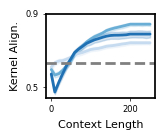

In [24]:
chosen_gamma = 0.8
fig, ax = plt.subplots(figsize=(1.75, 1.5))
custom_blues = sns.color_palette("Blues", n_colors=3)
sns.lineplot(
    data=dist_results[dist_results['gamma']==chosen_gamma],
    x='seq_length', y='diff', hue='layer', palette=custom_blues,
    linewidth=2,
    ax=ax, legend=False)
ax.axhline(
    np.mean(baseline_dist_results[baseline_dist_results['gamma']==chosen_gamma]['diff']),
    color='gray', linestyle='--',
    linewidth=2,
    label='Baseline'
)
label_fontsize = 8
tick_fontsize = 6
ax.set_xlabel('Context Length', fontsize=label_fontsize)
ax.set_ylabel('Kernel Align.', fontsize=label_fontsize)
plt.yticks([0.5, 0.9], fontsize=tick_fontsize)
plt.xticks(fontsize=tick_fontsize)
ylims = ax.get_ylim()
plt.tight_layout()
plt.savefig('figs/3c.png', transparent=True, dpi=300)
plt.savefig('figs/3c.svg', transparent=True, dpi=300)
plt.show()

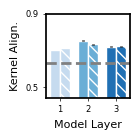

In [30]:
fig, ax = plt.subplots(figsize=(1.5, 1.5))
_dist_results = dist_results[dist_results['seq_length']==250]
data = dist_results[dist_results['gamma'] == chosen_gamma]
n_layers = len(data['layer'].unique())
width = 0.35  # Width of the bars

# Get cubehelix color palette that goes from light to dark purple
custom_blues = sns.color_palette("Blues", n_colors=3)

# Create x positions for the bars
x = np.arange(n_layers)

# Plot bars for each layer with corresponding colors
for i, layer in enumerate(range(n_layers)):
    layer_data = data[data['layer'] == layer]
    # Calculate means and standard errors
    diff_mean = layer_data['diff'].mean()
    diff_sem = layer_data['diff'].std() / np.sqrt(len(layer_data))
    no_reward_mean = layer_data['diff_no_reward'].mean()
    no_reward_sem = layer_data['diff_no_reward'].std() / np.sqrt(len(layer_data))
    
    # Plot 'diff' bars with error bars
    ax.bar(x[i] - width/2, diff_mean, 
           width, color=custom_blues[i], label=f'Layer {layer}' if i == 0 else "")
    ax.errorbar(x[i] - width/2, diff_mean, yerr=diff_sem, 
                color='black', capsize=0, fmt='none', linewidth=2)
    
    # Plot 'diff_no_reward' bars with error bars
    ax.bar(x[i] + width/2, no_reward_mean, 
           width, color=custom_blues[i], hatch='\\\\\\',
           edgecolor='white',
           label=f'Layer {layer} (No Reward)' if i == 0 else "")
    ax.errorbar(x[i] + width/2, no_reward_mean, yerr=no_reward_sem, 
                color='black', capsize=0, fmt='none', linewidth=2)

ax.axhline(
    np.mean(baseline_dist_results[baseline_dist_results['gamma']==chosen_gamma]['diff']),
    color='gray', linestyle='--',
    linewidth=2,
    label='Baseline'
)

# Customize the plot
ax.set_xlabel('Model Layer', fontsize=label_fontsize)
ax.set_ylabel('Kernel Align.', fontsize=label_fontsize)
ax.set_xticks(x)
ax.set_xticklabels(np.arange(n_layers)+1, fontsize=tick_fontsize)
plt.yticks([0.5, 0.9], fontsize=tick_fontsize)
plt.tight_layout()
plt.ylim(ylims)
plt.savefig('figs/3d.png', transparent=True, dpi=300)
plt.savefig('figs/3d.svg', transparent=True, dpi=300)
plt.show()

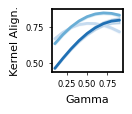

In [27]:
fig, ax = plt.subplots(figsize=(5.5/4, 1.25))
custom_palette = sns.color_palette("Blues", n_colors=3)
sns.lineplot(
    data=dist_results[dist_results['seq_length']==250],
    x='gamma', y='diff', hue='layer', palette=custom_palette,
    linewidth=2,
    ax=ax, legend=False)
plt.xlabel('Gamma', fontsize=8)
plt.ylabel('Kernel Align.', fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig('figs_app/G_17A.png', transparent=True, dpi=300)
plt.savefig('figs_app/G_17A.pdf', transparent=True, dpi=300)
plt.show()

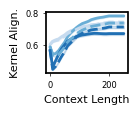

In [29]:
fig, ax = plt.subplots(figsize=(5.5/4 + 0.1, 1.25))
custom_palette = sns.color_palette("Blues", n_colors=3)
sns.lineplot(
    data=dist_results, x='seq_length', y='diff', hue='layer', palette=custom_palette,
    linewidth=2,
    ax=ax, legend=False)
sns.lineplot(
    data=dist_results, x='seq_length', y='diff_no_reward', hue='layer', palette=custom_palette,
    linewidth=2, linestyle='--',
    ax=ax, legend=False)
plt.xlabel('Context Length', fontsize=8)
plt.ylabel('Kernel Align.', fontsize=8)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig('figs_app/G_17B.png', transparent=True, dpi=300)
plt.savefig('figs_app/G_17B.pdf', transparent=True, dpi=300)
plt.show()
